In [17]:
!pip install -q pandasql


  Preparing metadata (setup.py) ... done


In [19]:
from google.colab import files
import pandas as pd

uploaded = files.upload()  # Choose your CSV file when prompted

# Load the uploaded CSV into a DataFrame
import io
df = pd.read_csv(io.BytesIO(uploaded['Sample_Yellow_Taxi_Trip_Data.csv']))
df.head()


Saving Sample_Yellow_Taxi_Trip_Data.csv to Sample_Yellow_Taxi_Trip_Data.csv


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2025-01-01 00:00:00,2025-01-01 00:30:00,4,11.051404,5,Y,264,263,3,28.402062,2.148251,1.0,12.909141,0.258296,0.3,45.017751,2.5,0.00
1,1,2025-01-01 01:00:00,2025-01-01 01:30:00,3,7.234407,4,N,15,264,6,46.442933,0.652849,1.0,3.513297,1.159892,0.3,53.068971,2.5,0.00
2,1,2025-01-01 02:00:00,2025-01-01 02:30:00,1,10.429975,4,Y,204,261,6,21.680857,0.942688,0.5,6.681172,1.499075,0.3,31.603792,2.5,1.25
3,2,2025-01-01 03:00:00,2025-01-01 03:30:00,1,6.106248,1,Y,44,179,6,30.891111,1.685550,1.0,13.294330,3.556493,0.3,50.727485,2.5,0.00
4,2,2025-01-01 04:00:00,2025-01-01 04:30:00,5,10.795334,4,N,94,197,3,42.587290,3.788753,1.0,5.623291,2.296645,0.3,55.595980,2.5,0.00


In [20]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())


In [21]:
query = """
SELECT PULocationID, SUM(total_amount) AS total_revenue
FROM df
GROUP BY PULocationID
ORDER BY total_revenue DESC
LIMIT 5;
"""
pysqldf(query)


,PULocationID,total_revenue
0,125,153.659283
1,200,147.483692
2,76,126.702351
3,236,126.399412
4,69,124.312336


In [22]:
query = """
SELECT AVG(passenger_count) AS avg_passenger_per_trip
FROM df;
"""
pysqldf(query)


,avg_passenger_per_trip
0,2.88


In [23]:
df['pickup_date'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.date

query = """
SELECT pickup_date, SUM(total_amount) AS daily_revenue
FROM df
GROUP BY pickup_date
ORDER BY pickup_date;
"""
pysqldf(query)


,pickup_date,daily_revenue
0,2025-01-01,1113.993619
1,2025-01-02,1139.905081
2,2025-01-03,1042.432757
3,2025-01-04,934.064574
4,2025-01-05,175.352152


In [24]:
result = pysqldf(query)
result.to_csv('query_output.csv', index=False)
files.download('query_output.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

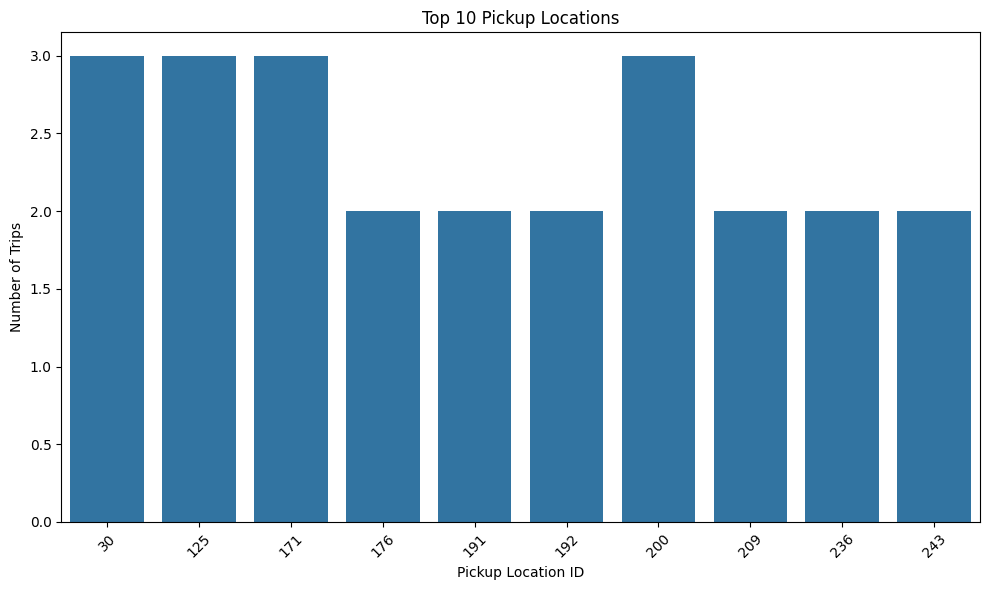

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Run your SQL query and load result
query = '''
SELECT PULocationID, COUNT(*) as trip_count
FROM df
GROUP BY PULocationID
ORDER BY trip_count DESC
LIMIT 10
'''
result = pysqldf(query)

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='PULocationID', y='trip_count', data=result)
plt.title('Top 10 Pickup Locations')
plt.xlabel('Pickup Location ID')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

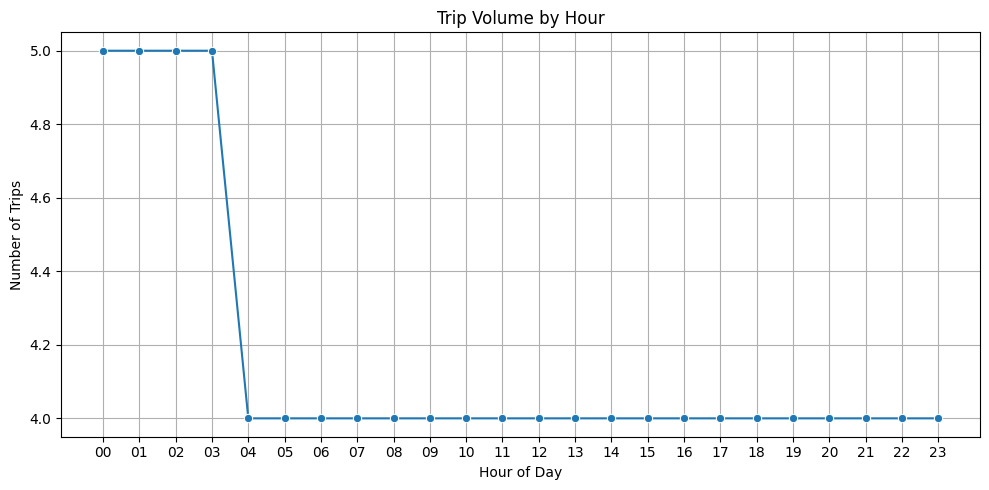

In [29]:
query = '''
SELECT strftime('%H', tpep_pickup_datetime) as hour, COUNT(*) as trip_count
FROM df
GROUP BY hour
ORDER BY hour
'''
hourly_trips = pysqldf(query)

# Line plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_trips, x='hour', y='trip_count', marker='o')
plt.title('Trip Volume by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.tight_layout()
plt.show()

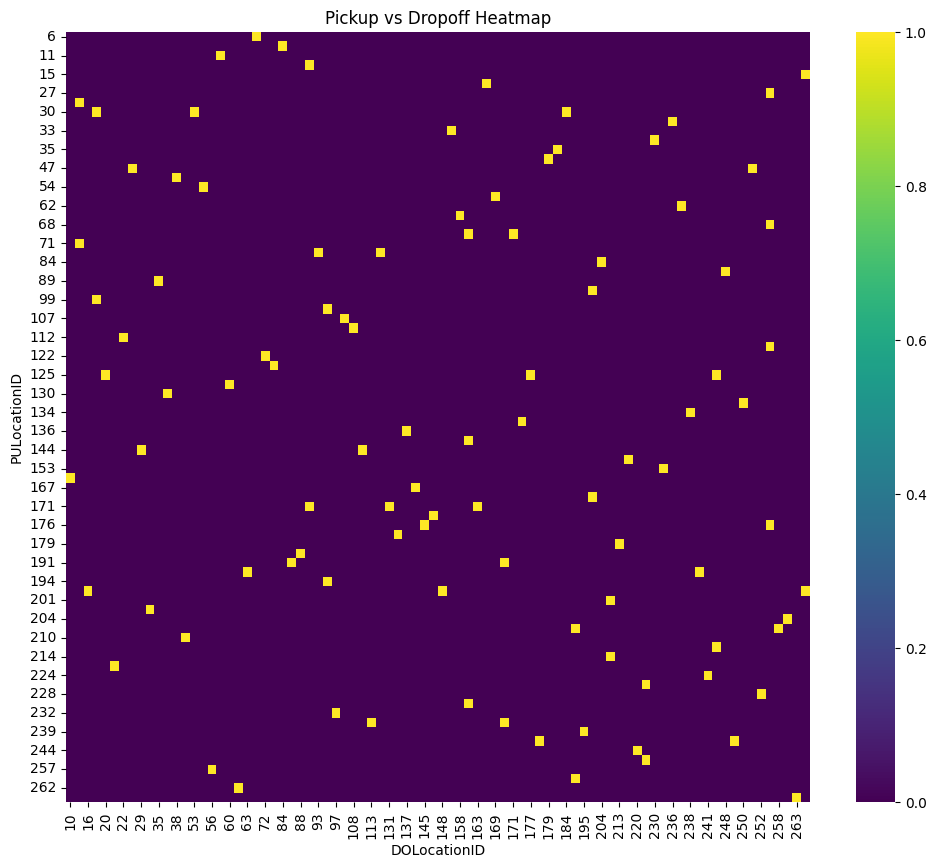

In [33]:
query = '''
SELECT PULocationID, DOLocationID, COUNT(*) as trip_count
FROM df
GROUP BY PULocationID, DOLocationID
'''
matrix = pysqldf(query)
pivot = matrix.pivot(index='PULocationID', columns='DOLocationID', values='trip_count').fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(pivot, cmap='viridis')
plt.title('Pickup vs Dropoff Heatmap')
plt.show()